In [2]:
import Playlist_Class as PC
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

# Goal
#### My goal is to use the data from tracks of different playlist types to identify traits that can be used to classify them, and then develop a Machine Learning model to classify tracks based on their features.

In [3]:
focus_playlists = PC.SpotifyPlaylist('focus', 'US', 25).tracks
workout_playlists = PC.SpotifyPlaylist('workout', 'US', 25).tracks
sleep_playlists = PC.SpotifyPlaylist('mood', 'US', 25).tracks
party_playlists = PC.SpotifyPlaylist('party', 'US', 25).tracks

BARK BARK BARK >:(
BARK BARK BARK >:(


Before concatenating all of our playlists into one big dataframe, we have to make sure that we label each song with its corresponding playlist. These categories will be our target column for classification

In [4]:
focus_playlists['playlist_type'] = ['focus']*len(focus_playlists)
workout_playlists['playlist_type'] = ['workout']*len(workout_playlists)
sleep_playlists['playlist_type'] = ['sleep']*len(sleep_playlists)
party_playlists['playlist_type'] = ['party']*len(party_playlists)

In [5]:
playlists = pd.concat([focus_playlists, workout_playlists, sleep_playlists, party_playlists])
len(playlists)

6851

Now that we've concatenated our data into one big playlist, we have to check one very important detail; whether tracks show up in multiple different types of playlists

In [6]:
playlists[playlists.duplicated(subset=['name', 'artists'], keep=False)].name.nunique()

443

First we query all songs in our playlist that are duplicated. Then using nunique we see that there are 443 songs that are repeated in at least one playlist. We have to decide what to do with these songs. 

It would be interesting to do some type of multilabel output classification. However, to do this I would need a more conclusive lists of tracks, since I can't verify which playlists a song belongs in without first getting a list of every track in each of the playlists present.

To keep things simple, it might be better to discard these border cases, and revisit the idea of a multilabel output in a cloud setting instead, so that I have the memory to fit all of the data and run computations.

In [7]:
playlists.drop_duplicates(subset=['name', 'artists'], inplace=True, keep=False)

In [8]:
assert not any(playlists.duplicated(subset=['name', 'artists'], keep=False))

In [23]:
len(playlists)

5891

We've dropped about 1000 records from our dataset. The border cases may still be present for the reason i mentioned earlier; We can't be sure if a track is present in another playlist type without getting every track from every playlist of all present playlist. Keeping this in mind let's proceed to the next part of our analysis.

# Preliminary Data Exploration

In [10]:
playlists.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5891 entries, 5z7sxlo3kf8eg8s3Zkb8dQ to 6lEAYlnuzxr0HHzdzXjBmx
Data columns (total 19 columns):
name                5891 non-null object
artists             5891 non-null object
album               5891 non-null object
duration_ms         5891 non-null int64
popularity          5891 non-null int64
acousticness        5891 non-null float64
danceability        5891 non-null float64
energy              5891 non-null float64
instrumentalness    5891 non-null float64
key                 5891 non-null category
liveness            5891 non-null float64
loudness            5891 non-null float64
mode                5891 non-null category
speechiness         5891 non-null float64
tempo               5891 non-null float64
time_signature      5891 non-null int64
valence             5891 non-null float64
rating              5891 non-null category
playlist_type       5891 non-null object
dtypes: category(3), float64(9), int64(3), object(4)
memory usage: 8

We see that we have 5891 entries, all non-null, and we have a good mix of categorical and numerical columns. We also see that our playlist_type column is of type object, let's make it of type category, since categorical variables take up less memory than string variables ( because of how pandas treats categorical vs object types)

In [11]:
playlists['playlist_type'] = playlists['playlist_type'].astype('category')

In [12]:
playlists.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5891 entries, 5z7sxlo3kf8eg8s3Zkb8dQ to 6lEAYlnuzxr0HHzdzXjBmx
Data columns (total 19 columns):
name                5891 non-null object
artists             5891 non-null object
album               5891 non-null object
duration_ms         5891 non-null int64
popularity          5891 non-null int64
acousticness        5891 non-null float64
danceability        5891 non-null float64
energy              5891 non-null float64
instrumentalness    5891 non-null float64
key                 5891 non-null category
liveness            5891 non-null float64
loudness            5891 non-null float64
mode                5891 non-null category
speechiness         5891 non-null float64
tempo               5891 non-null float64
time_signature      5891 non-null int64
valence             5891 non-null float64
rating              5891 non-null category
playlist_type       5891 non-null category
dtypes: category(4), float64(9), int64(3), object(3)
memory usage:

In [14]:
playlists['playlist_type'].value_counts()

focus      1933
sleep      1519
workout    1231
party      1208
Name: playlist_type, dtype: int64

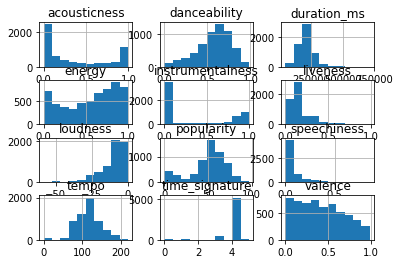

In [15]:
playlists.hist()
plt.show()

A quick glance at the data tells us that some of the columns are skewed.So we may want to look into the possibilty of applying transformations to adjust our data.

In [16]:
playlists.describe()

,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence
count,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000
mean,207841.827024,50.619080,0.360794,0.571350,0.559457,0.325262,0.178202,-10.892709,0.083633,117.194928,3.847734,0.418406
std,64502.350202,20.024388,0.379825,0.196517,0.304980,0.407037,0.151285,8.739103,0.088766,32.554296,0.636525,0.264611
min,41290.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-58.555000,0.000000,0.000000,0.000000,0.000000
25%,169652.000000,43.000000,0.021950,0.456500,0.292500,0.000002,0.095700,-14.084000,0.037250,95.053000,4.000000,0.192000
50%,202105.000000,54.000000,0.175000,0.602000,0.629000,0.005060,0.116000,-7.591000,0.050000,120.018000,4.000000,0.392000
75%,236806.000000,64.000000,0.772500,0.714500,0.826000,0.845000,0.203000,-5.053000,0.085350,135.143500,4.000000,0.622000
max,719133.000000,97.000000,0.996000,0.983000,1.000000,1.000000,0.985000,0.101000,0.855000,218.418000,5.000000,0.991000


We see that our numeric columns are on very different scales, so we will definitely have to normalize our columns. Especially if we are going to be using models such as KNN

### So from our preliminary look at the data we learned a couple things:
- We have a good amount of categorical columns, so we will have to perform some type of encoding to transform these categorical values into numerical ones before running our data through a model.
- Each playlist type is well represented, but we have more examples of some than others.
- We don't have null values since we removed them during our extraction and transformation of the data from the Spotify API.
- Our numeric columns are on vastly different scales so we will have to normalize the data if we plan on using certain technique(techniques where the scale/variation of the data matters)
- Some of our numeric columns are skewed so we can explore the possibility of applying transformations to standardize the model.
- Since we concatenated the playlists, they are all in consecutive order. So we will have to shuffle the examples before splitting our set up into a test and training set.

# Create a Test Set

To avoid data snooping, we will separate a test set before continuing our analysis. We will create a training and test csv file so that we don't have to reacquire the data from Spotify. We use Stratefied Shuffle Split to ensure that we have a good mix of each type of playlist in both the test and training set.

In [17]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in split.split(playlists, playlists['playlist_type']):
    train_set = playlists.iloc[train_index]
    test_set = playlists.iloc[test_index]

In [18]:
playlists['playlist_type'].value_counts() / len(playlists)

focus      0.328128
sleep      0.257851
workout    0.208963
party      0.205059
Name: playlist_type, dtype: float64

In [19]:
train_set["playlist_type"].value_counts() / len(train_set)

focus      0.328098
sleep      0.257852
workout    0.209041
party      0.205008
Name: playlist_type, dtype: float64

In [20]:
test_set["playlist_type"].value_counts() / len(test_set)

focus      0.328244
sleep      0.257846
workout    0.208651
party      0.205259
Name: playlist_type, dtype: float64

Using the Stratefied Shuffle Split strategy we were able to generate a training and test set with almost identical playlist_type category proportions as those in the full dataset. Now we can export these dataframes into separate .csv files before continuing our full analysis. 

In [21]:
train_set.to_csv('training_data.csv')

In [22]:
test_set.to_csv('test_data.csv')

We've successfully created our training and test set. We will do all of our exploration and develop our model using the training set, before finally trying it out on our test set.